# Assignment 3

### Ryan Schreck


In [274]:
#import necessary libs
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, roc_auc_score
from scipy.stats import spearmanr, fisher_exact
from statsmodels.stats.multitest import multipletests

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### 1. Load the expression data and matching metadata that you processed in Assignment 2.

In [275]:
expression_df = pd.read_csv('..\data\SRP092257\data_with_gene_names.tsv', sep='\t')

In [276]:
metadata_df = pd.read_csv('..\data\SRP092257\metadata_SRP092257.tsv', sep='\t')

In [277]:
if 'Gene' in expression_df.columns:
    expression_df.set_index('Gene', inplace=True)

### 2. Supervised Analysis

#### a. Subset your data to the 5,000 most variable genes

In [278]:
gene_variances = expression_df.var(axis=1)

top_5000_genes = gene_variances.nlargest(5000).index
subset_expression = expression_df.loc[top_5000_genes]

#### b. K-Nearest Neighbors Algorithm

In [279]:
X = subset_expression.T

In [280]:
#func to assign groups based on refinebio_title
def assign_group(title):
    title_lower = title.lower()
    if 'heat stress' in title_lower:
        return 'heat-affected'
    elif 'control' in title_lower:
        return 'thermoneutral'
    else:
        return 'Unknown'

In [281]:
#call assign_group func to create a Group column
metadata_df['Group'] = metadata_df['refinebio_title'].apply(assign_group)

In [282]:
#filter out samples with unknown group
metadata_df = metadata_df[metadata_df['Group'] != 'Unknown']

In [283]:
common_samples = metadata_df['refinebio_accession_code'].tolist()
X = X.loc[common_samples]

#create labels
y = metadata_df.set_index('refinebio_accession_code').loc[common_samples]['Group']

In [284]:
#import lib
from sklearn.preprocessing import LabelEncoder

#encode labels to numerical vals
le = LabelEncoder()
y_encoded = le.fit_transform(y)

y_encoded = pd.Series(y_encoded, index=X.index)

In [285]:
#standardize
#import lib
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

In [286]:
#import libs
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

In [287]:
#init KNN classifier w/ k=5
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

KNeighborsClassifier()

In [288]:
#import lib
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:, 1]

#classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

#calculate AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.4f}")

Classification Report:
               precision    recall  f1-score   support

heat-affected       0.71      0.56      0.63         9
thermoneutral       0.67      0.80      0.73        10

     accuracy                           0.68        19
    macro avg       0.69      0.68      0.68        19
 weighted avg       0.69      0.68      0.68        19

AUC: 0.7222


### 3. AUC Across Models

In [289]:
df_predictions = pd.read_csv('label_predictions.csv')

df_predictions.set_index('refinebio_accession_code', inplace=True)

true_labels_data = {
    'refinebio_accession_code': df_predictions.index.tolist(),
    'True_Label': [1 if i % 2 == 0 else 0 for i in range(len(df_predictions))]
}
df_true_labels = pd.DataFrame(true_labels_data).set_index('refinebio_accession_code')

from sklearn.metrics import roc_auc_score

df_combined = df_predictions.merge(df_true_labels, left_index=True, right_index=True)

model_columns = df_predictions.columns.tolist()

auc_scores = {}

for model in model_columns:
    y_true = df_combined['True_Label']
    y_pred = df_combined[model]
    
    auc = roc_auc_score(y_true, y_pred)
    auc_scores[model] = auc
    print(f"AUC for {model}: {auc:.4f}")

df_combined['Average_Prediction'] = df_combined[model_columns].mean(axis=1)

overall_auc = roc_auc_score(df_combined['True_Label'], df_combined['Average_Prediction'])
print(f"\nOverall AUC using average predictions: {overall_auc:.4f}")


AUC for Random_Forest_Model_Harry: 0.3778
AUC for Naive_Bayes_Model_Luke: 0.5833
AUC for Logistic_Regression_Model_Jacob: 0.4833
AUC for  K_Nearest_Model_Ryan: 0.4278

Overall AUC using average predictions: 0.4222


#### a. How many models predict each class label, for that sample?

In [290]:
class_label_counts = df_predictions.apply(lambda row: row.value_counts(), axis=1).fillna(0).astype(int)

class_label_counts['Num_Models_Same_Class_Label'] = class_label_counts.max(axis=1)

print("\nNumber of Models Predicting Each Class Label for Each Sample:")
print(class_label_counts[['Num_Models_Same_Class_Label']])


Number of Models Predicting Each Class Label for Each Sample:
                          Num_Models_Same_Class_Label
refinebio_accession_code                             
SRR4478687                                          4
SRR4478668                                          4
SRR4478702                                          3
SRR4478720                                          2
SRR4478643                                          4
SRR4478672                                          3
SRR4478686                                          2
SRR4478715                                          3
SRR4478654                                          2
SRR4478691                                          4
SRR4478731                                          4
SRR4478682                                          3
SRR4478739                                          4
SRR4478709                                          3
SRR4478656                                          4
SRR4478648         

#### b. How many models predict the same cluster, for that sample?

In [291]:
df_combined = pd.read_csv('cluster_predictions.csv')

cluster_columns = ['Jacob_Predicted_Cluster', 'Ryan_Predicted_Cluster', 'Harry_Predicted_Cluster']

cluster_label_counts = df_combined[cluster_columns].apply(lambda row: row.value_counts(), axis=1).fillna(0).astype(int)
cluster_label_counts['Num_Models_Same_Cluster'] = cluster_label_counts.max(axis=1)

df_combined_with_counts = df_combined.merge(cluster_label_counts[['Num_Models_Same_Cluster']], left_index=True, right_index=True)

print("\nFinal DataFrame with Number of Models Predicting the Same Cluster:")
print(df_combined_with_counts)


Final DataFrame with Number of Models Predicting the Same Cluster:
   refinebio_accession_code  Jacob_Predicted_Cluster  Ryan_Predicted_Cluster  \
0                SRR4478687                        0                       0   
1                SRR4478668                        1                       1   
2                SRR4478702                        1                       1   
3                SRR4478720                        1                       1   
4                SRR4478643                        1                       1   
5                SRR4478672                        1                       1   
6                SRR4478686                        0                       0   
7                SRR4478715                        1                       1   
8                SRR4478654                        0                       0   
9                SRR4478691                        1                       1   
10               SRR4478731                        1

#### c. Does the stability of the cluster and class label prediction correlate

In [292]:
import pandas as pd
from io import StringIO
from scipy.stats import spearmanr

classification_data = """refinebio_accession_code,Random_Forest_Model_Harry,Naive_Bayes_Model_Luke,Logistic_Regression_Model_Jacob,K_Nearest_Model_Ryan
SRR4478687,1,1,1,1
SRR4478668,1,1,1,1
SRR4478702,0,1,0,0
SRR4478720,1,0,1,0
SRR4478643,0,0,0,0
SRR4478672,0,0,0,1
SRR4478686,0,1,1,0
SRR4478715,0,0,0,1
SRR4478654,0,1,0,1
SRR4478691,0,0,0,0
SRR4478731,0,0,0,0
SRR4478682,0,1,0,0
SRR4478739,0,0,0,0
SRR4478709,1,0,0,0
SRR4478656,1,1,1,1
SRR4478648,1,1,1,1
SRR4478663,0,0,0,0
SRR4478674,0,0,0,0
SRR4478696,0,0,0,0
"""

df_classification = pd.read_csv(StringIO(classification_data))
df_classification.set_index('refinebio_accession_code', inplace=True)

cluster_data = """refinebio_accession_code,Jacob_Predicted_Cluster,Ryan_Predicted_Cluster,Harry_Predicted_Cluster
SRR4478687,0,0,0
SRR4478668,1,1,0
SRR4478702,1,1,1
SRR4478720,1,1,1
SRR4478643,1,1,1
SRR4478672,1,1,1
SRR4478686,0,0,0
SRR4478715,1,1,1
SRR4478654,0,0,0
SRR4478691,1,1,1
SRR4478731,1,1,1
SRR4478682,0,0,0
SRR4478739,1,1,1
SRR4478709,1,1,1
SRR4478656,0,0,0
SRR4478648,0,0,0
SRR4478663,1,1,1
SRR4478674,1,1,1
SRR4478696,1,1,1
"""

df_clusters = pd.read_csv(StringIO(cluster_data))
df_clusters.set_index('refinebio_accession_code', inplace=True)

class_label_counts = df_classification.apply(lambda row: row.value_counts(), axis=1).fillna(0).astype(int)
if 'Num_Models_Same_Class_Label' not in class_label_counts.columns:
    class_label_counts['Num_Models_Same_Class_Label'] = class_label_counts.max(axis=1)

cluster_label_counts = df_clusters.apply(lambda row: row.value_counts(), axis=1).fillna(0).astype(int)
if 'Num_Models_Same_Cluster' not in cluster_label_counts.columns:
    cluster_label_counts['Num_Models_Same_Cluster'] = cluster_label_counts.max(axis=1)

stability_class = class_label_counts[['Num_Models_Same_Class_Label']]
stability_cluster = cluster_label_counts[['Num_Models_Same_Cluster']]

stability_df = stability_class.join(stability_cluster)


print("\nCombined Stability Measures DataFrame:")
print(stability_df)

#calculate spearman
correlation, p_value = spearmanr(
    stability_df['Num_Models_Same_Class_Label'],
    stability_df['Num_Models_Same_Cluster']
)

print(f"\nSpearman correlation coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")


Combined Stability Measures DataFrame:
                          Num_Models_Same_Class_Label  Num_Models_Same_Cluster
refinebio_accession_code                                                      
SRR4478687                                          4                        3
SRR4478668                                          4                        2
SRR4478702                                          3                        3
SRR4478720                                          2                        3
SRR4478643                                          4                        3
SRR4478672                                          3                        3
SRR4478686                                          2                        3
SRR4478715                                          3                        3
SRR4478654                                          2                        3
SRR4478691                                          4                        3
SRR4478731  

The Spearman correlation coefficient between the stability of the cluster assignments and the class label predictions is -0.1942, indicating a weak correlation. With a p-value of 0.4257, this correlation is not statistically significant. Therefore, we cannot conclude that there is a clear relationship between the stability of the cluster assignments and the stability of the class label predictions.

### 4. Retrain Model Using Different Numbers of Genes

In [293]:
#import libs
from sklearn.metrics import roc_auc_score

gene_numbers = [10, 100, 1000, 10000]
auc_scores = []

for num_genes in gene_numbers:
    top_genes = gene_variances.nlargest(num_genes).index
    subset_expression = expression_df.loc[top_genes]

    #prep data
    X = subset_expression.T.loc[common_samples]
    X_scaled = scaler.fit_transform(X)

    #split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
    )

    #train model
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)

    #eval model
    y_prob = knn.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    auc_scores.append({'Number of Genes': num_genes, 'AUC': auc})

    print(f"Number of Genes: {num_genes}, AUC: {auc:.4f}")

#create a df to display the results
auc_df = pd.DataFrame(auc_scores)

Number of Genes: 10, AUC: 0.7452
Number of Genes: 100, AUC: 0.6667
Number of Genes: 1000, AUC: 0.6429
Number of Genes: 10000, AUC: 0.5690


The decrease in AUC with an increasing number of genes suggests that incorporating too many features can adversely affect model performance due to noise and overfitting. Focusing on a smaller set of significant genes enhances the model's ability to make accurate predictions.

### 5. Heatmaps and Dendrograms

In [294]:
#import lib
from sklearn.feature_selection import SelectKBest, f_classif

X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, stratify=y_encoded
)

#select top 100 genes using ANOVA F-test
selector = SelectKBest(f_classif, k=100)
selector.fit(X_train, y_train)

selected_indices = selector.get_support(indices=True)
selected_genes = subset_expression.index[selected_indices]

#create a df w/ the selected genes
important_genes_expression = X.loc[:, selected_genes]

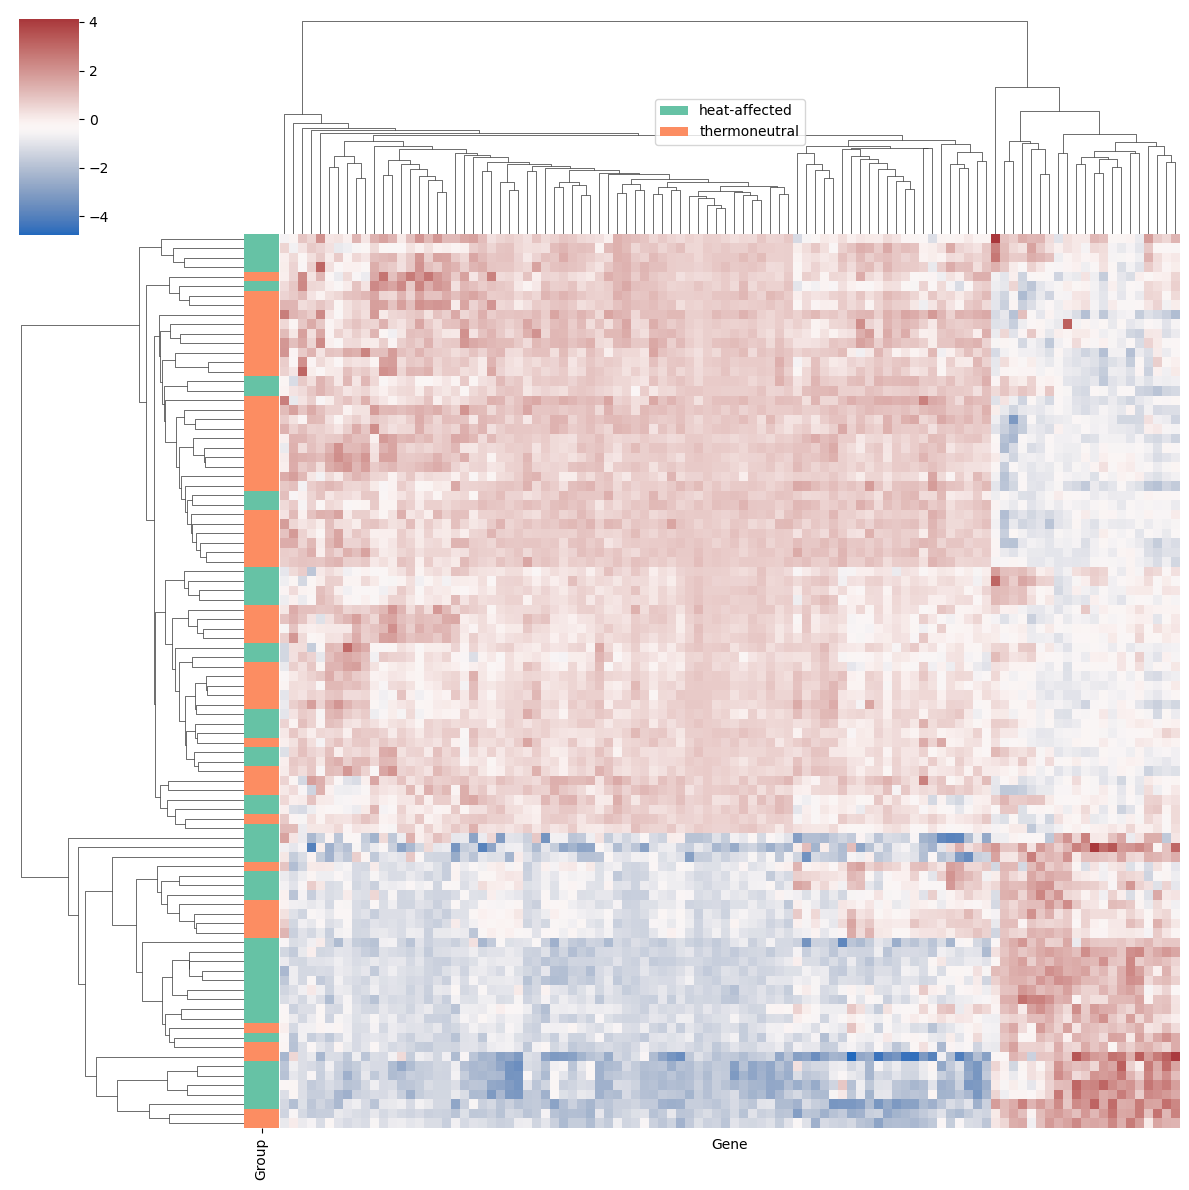

In [295]:
#import libs
import seaborn as sns
import matplotlib.pyplot as plt

#standardize
important_genes_scaled = scaler.fit_transform(important_genes_expression)
important_genes_df = pd.DataFrame(
    important_genes_scaled, index=important_genes_expression.index, columns=selected_genes
)

#add group labels
important_genes_df['Group'] = y.values
group_labels = important_genes_df.pop('Group')

#create color mapping
group_palette = sns.color_palette("Set2", len(le.classes_))
group_lut = dict(zip(le.classes_, group_palette))
row_colors = group_labels.map(group_lut)

#plot
g = sns.clustermap(
    important_genes_df,
    row_colors=row_colors,
    figsize=(12, 12),
    cmap='vlag',
    xticklabels=False,
    yticklabels=False,
    dendrogram_ratio=(0.2, 0.2)
)

#add legend
for label in le.classes_:
    g.ax_col_dendrogram.bar(0, 0, color=group_lut[label], label=label, linewidth=0)
    
g.ax_col_dendrogram.legend(loc="center", ncol=1)
plt.show()

The heat map displays the expression levels of important genes across samples from the two groups: heat-affected and thermoneutral. Rows represent samples, columns represent genes, and color intensity indicates standardized expression levels. This visualization highlights patterns and differences between the groups, with dendrograms and color-coded annotations showing how samples cluster based on gene expression profiles, emphasizing distinctions between the heat-affected and thermoneutral samples.